In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

from statsmodels.graphics.mosaicplot import mosaic

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn import metrics

import ot

import time
import random

In [90]:
original_data = pd.read_csv(
    "adult.csv",
    usecols=[
        "age", "educational-num", "gender", "capital-gain", "capital-loss", "hours-per-week", "income"],
    sep=r'\s*,\s*',
    engine='python',
    na_values="?",
    )

original_data = original_data[["age", "educational-num", "capital-gain", "capital-loss", "hours-per-week", "gender", "income"]]

print(original_data.head())
print(original_data.tail())

   age  educational-num  capital-gain  capital-loss  hours-per-week  gender  \
0   25                7             0             0              40    Male   
1   38                9             0             0              50    Male   
2   28               12             0             0              40    Male   
3   44               10          7688             0              40    Male   
4   18               10             0             0              30  Female   

  income  
0  <=50K  
1  <=50K  
2   >50K  
3   >50K  
4  <=50K  
       age  educational-num  capital-gain  capital-loss  hours-per-week  \
48837   27               12             0             0              38   
48838   40                9             0             0              40   
48839   58                9             0             0              40   
48840   22                9             0             0              20   
48841   52                9         15024             0              40   

       g

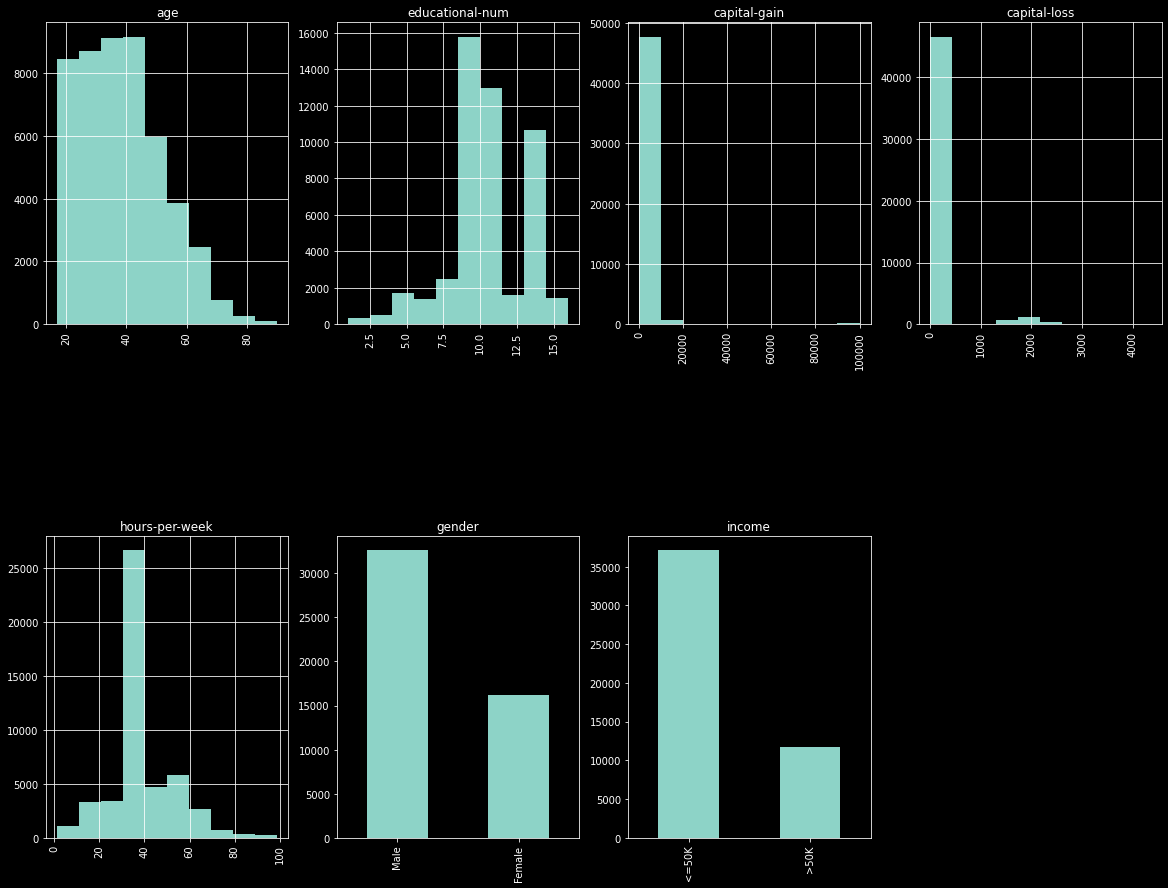

In [91]:
data=original_data.copy()

fig = plt.figure(figsize=(20,15))
cols = 4
rows = int(np.ceil(float(data.shape[1]) / cols))
for i, column in enumerate(data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data.dtypes[column] == object:
        data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

Mosaic plot:


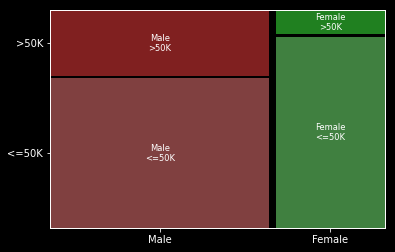

In [92]:
print('Mosaic plot:')

mosaic(data, ['gender','income'],gap=0.02)
# plt.savefig('mosaic1.pdf')
plt.show()

Total number of samples: 10000
Number of Male samples: 6674
Number of Female samples: 3326
Mosaic plot:


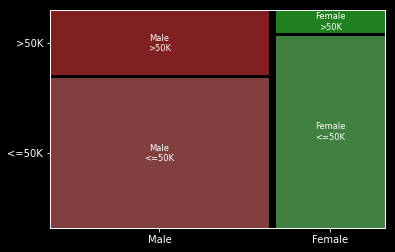

In [93]:
NUMBER_TOTAL = 10000
NUMBER_MALE = 0
NUMBER_FEMALE = 0
LAMBDA = 0

using_data = data.sample(NUMBER_TOTAL)

for index, row in using_data.iterrows():
    if row['gender'] == 'Male':
        NUMBER_MALE += 1
    else:
        NUMBER_FEMALE += 1
        
print(f"Total number of samples: {len(using_data)}")
print(f"Number of Male samples: {NUMBER_MALE}")
print(f"Number of Female samples: {NUMBER_FEMALE}")

print('Mosaic plot:')

mosaic(using_data, ['gender','income'],gap=0.02)
# plt.savefig('mosaic2.pdf')
plt.show()

In [94]:
data_ohe=using_data.copy()

data_ohe['income'] = np.where(data_ohe['income']=='>50K', 1., 0.)
print('In column Income: >50K gets 1 and <= 50K gets 0')


data_ohe['gender'] = np.where(data_ohe['gender']=='Male', 1., 0.)
print('In column gender: male gets 1 and female gets 0')

data_ohe.tail()

In column Income: >50K gets 1 and <= 50K gets 0
In column gender: male gets 1 and female gets 0


,age,educational-num,capital-gain,capital-loss,hours-per-week,gender,income
48076,58,14,7688,0,30,1.0,1.0
14626,61,13,0,0,30,0.0,1.0
4821,55,9,0,0,35,0.0,0.0
26902,38,9,7298,0,50,1.0,1.0
13742,32,10,0,0,55,0.0,0.0


In [95]:
y = data_ohe['income'].values.reshape(-1, 1)
protected_x = data_ohe['gender'].values.reshape(-1, 1)

other_x = data_ohe.drop(columns=['gender', 'income'])
X_col_names = list(other_x.columns)

X_wo_gender = other_x.values

print(y.shape, protected_x.shape, X_wo_gender.shape)
print(X_col_names)

(10000, 1) (10000, 1) (10000, 5)
['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [96]:
X_scaled = sk.preprocessing.scale(X_wo_gender)

X  = np.concatenate((X_scaled, protected_x), axis=1)

print(X.shape)

(10000, 6)


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


print('n_train=',X_train.shape[0])
print('n_test=',X_test.shape[0])
print('p=',X_test.shape[1])

NUMBER_TEST = X_test.shape[0]

n_train= 6700
n_test= 3300
p= 6


In [98]:
before = LogisticRegression(solver='lbfgs',max_iter=10000)

before.fit(X_train,y_train.ravel())

y_test_pred_LR=before.predict(X_test)

print('Done Training and Predicting')

Done Training and Predicting


In [99]:
acc=accuracy_score(y_test.ravel(),y_test_pred_LR.ravel())

count_m = 0
count_f = 0

total_m = 0
total_f = 0

for i in range(NUMBER_TEST):
    if X_test[i][-1] == 1:
        total_m += 1
        if y_test_pred_LR[i] == 1:
            count_m += 1
    else:
        total_f += 1
        if y_test_pred_LR[i] == 1:
            count_f += 1

prob_s_0 = count_f / total_f
prob_s_1 = count_m / total_m
di = prob_s_0/ prob_s_1

print(f'Accuracy: {acc}')
print(f'Disparate Impact: {di}')

Accuracy: 0.8209090909090909
Disparate Impact: 0.11073189018010508


In [100]:
men_X = []
men_Y = []

women_X = []
women_Y = []

for i in range(NUMBER_TOTAL):
    if X[i][-1] == 1:
        men_X.append(X[i])
        men_Y.append(y[i])
    else:
        women_X.append(X[i])
        women_Y.append(y[i])

In [101]:
men_X = np.array(men_X)
men_Y = np.array(men_Y)
women_X = np.array(women_X)
women_Y = np.array(women_Y)

print(men_X.shape, men_Y.shape, women_X.shape, women_Y.shape)

(6674, 6) (6674, 1) (3326, 6) (3326, 1)


In [102]:
cost_matrix = np.zeros((NUMBER_FEMALE, NUMBER_MALE))

for i in range(NUMBER_MALE):
    for j in range(NUMBER_FEMALE):
        dist = 0
        for k in range(6):
            if k == 5:
                continue
            dist = dist + (men_X[i][k] - women_X[j][k])**2
        dist = dist**0.5
        cost_matrix[j][i] = dist
        
mat_men = np.array([1/NUMBER_MALE] * NUMBER_MALE)
mat_women = np.array([1/NUMBER_FEMALE] * NUMBER_FEMALE)

print(mat_men.shape, mat_women.shape, cost_matrix.shape)

(6674,) (3326,) (3326, 6674)


In [103]:
start = time.time()
ot_emd = ot.emd(mat_women, mat_men, cost_matrix)
time_emd = time.time() - start

print(f"Time taken: {time_emd}")

print(ot_emd.shape)

print(f"sum of first row of transport plan: {sum(ot_emd[0])}")
print(f"Required sum of first row: {1/NUMBER_FEMALE}")

print(sum([sum(ot_emd[i]) for i in range(ot_emd.shape[0])]))

t_plan = pd.DataFrame(ot_emd)
t_plan.to_csv("Transport_Matrix.csv")

d:\python\lib\site-packages\ot\lp\__init__.py:343: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Time taken: 5.912126541137695
(3326, 6674)
sum of first row of transport plan: 0.0003006614552014432
Required sum of first row: 0.0003006614552014432
1.0000000000000577


In [104]:
tp = ot_emd.copy()

for i in range(NUMBER_FEMALE):
    for j in range(1, NUMBER_MALE):
        tp[i][j] = tp[i][j-1] + tp[i][j]
        
for i in range(NUMBER_FEMALE):
    for j in range(NUMBER_MALE):
        tp[i][j] = tp[i][j] * NUMBER_FEMALE

In [111]:
def get_acc_di(given_data):
    X_after_OT = given_data[:, list(range(6))]
    y_after_ot = given_data[:,6]
    
    X_train_after_ot, X_test_after_ot, y_train_after_ot, y_test_after_ot = train_test_split(X_after_OT, y_after_ot, test_size=0.33)

    NUMBER_TEST_AFTER_OT = X_test_after_ot.shape[0]
    
    after = LogisticRegression(solver='lbfgs',max_iter=10000)

    after.fit(X_train_after_ot,y_train_after_ot.ravel())

    y_test_pred_LR=after.predict(X_test_after_ot)

    # print('Done Training and Predicting')
    
    acc_in_fun=accuracy_score(y_test_after_ot.ravel(),y_test_pred_LR.ravel())
    
    count_m = 0
    count_f = 0

    total_m = 0
    total_f = 0

    for i in range(NUMBER_TEST_AFTER_OT):
        if X_after_OT[i][-1] == 1:
            total_m += 1
            if y_test_pred_LR[i] == 1:
                count_m += 1
        else:
            total_f += 1
            if y_test_pred_LR[i] == 1:
                count_f += 1

    # print(count_m, count_f, total_m, total_f)
    
    prob_s_0 = count_f / total_f
    prob_s_1 = count_m / total_m
    # print(prob_s_0, prob_s_1)
    di_in_fun = prob_s_0/prob_s_1
    # print(f"Disparate impact: {di}")
    
    return acc_in_fun, di_in_fun

In [122]:
accs = [acc]
dis = [di]
lambdas = [0]

In [123]:
for l in range(1, 101):
    women_X_after_ot = women_X.copy()
    LAMBDA = l * 0.01
    lambdas.append(LAMBDA)
    number_replacements = 0

    for i in range(NUMBER_FEMALE):
        s1 = random.uniform(0, 1)
        
        if s1 > LAMBDA:
            continue
        
        number_replacements += 1
        sample = random.uniform(0, 1)
        
        index = 0
        while tp[i][index+1] < sample:
            index += 1
        # print(index)
        for j in range(5):
            women_X_after_ot[i][j] = men_X[index][j]
            
    # print(f'{LAMBDA} x {NUMBER_FEMALE} = {LAMBDA * NUMBER_FEMALE}')
    # print(f'Number of replacements = {number_replacements}')

    men_final = np.concatenate((men_X, men_Y), axis=1)
    women_final = np.concatenate((women_X_after_ot, women_Y), axis=1)

    # print(men_final.shape, women_final.shape)

    data_after_OT = np.concatenate((women_final, men_final))

    # print(data_after_OT.shape)

    np.random.shuffle(data_after_OT)
    # print(data_after_OT[:10])
    acc_t, di_t = get_acc_di(data_after_OT)
    
    accs.append(acc_t)
    dis.append(di_t)
    
print(accs)
print(dis)
print(lambdas)

[0.8209090909090909, 0.8290909090909091, 0.8209090909090909, 0.8227272727272728, 0.8193939393939393, 0.8206060606060606, 0.8196969696969697, 0.8290909090909091, 0.826060606060606, 0.816969696969697, 0.8178787878787879, 0.8221212121212121, 0.8151515151515152, 0.8193939393939393, 0.8212121212121212, 0.8281818181818181, 0.813939393939394, 0.8175757575757576, 0.8181818181818182, 0.8184848484848485, 0.826060606060606, 0.813939393939394, 0.8257575757575758, 0.8175757575757576, 0.8151515151515152, 0.8142424242424242, 0.8063636363636364, 0.8212121212121212, 0.82, 0.8106060606060606, 0.8151515151515152, 0.8124242424242424, 0.8227272727272728, 0.8075757575757576, 0.8045454545454546, 0.8175757575757576, 0.8145454545454546, 0.816969696969697, 0.8042424242424242, 0.8136363636363636, 0.8136363636363636, 0.8045454545454546, 0.816969696969697, 0.8148484848484848, 0.8033333333333333, 0.823030303030303, 0.8121212121212121, 0.8106060606060606, 0.8142424242424242, 0.806060606060606, 0.8042424242424242, 0.

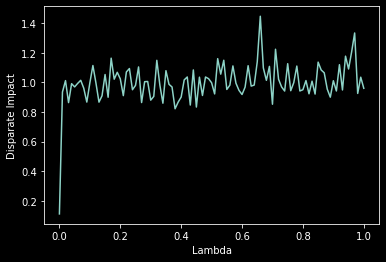

In [124]:
plt.plot(lambdas, dis)

plt.xlabel("Lambda")
plt.ylabel("Disparate Impact")

plt.show()

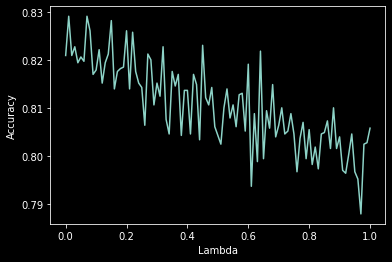

In [126]:
plt.plot(lambdas, accs)

plt.xlabel("Lambda")
plt.ylabel("Accuracy")

plt.show()